# parallel generate training samples with different Kd, source loc + source strength.

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle as pk
from smt.sampling_methods import LHS
from my_model import mymf
import sys
import os
import numpy as np
import matplotlib as mpl
import pickle as pk
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import shutil
from IPython.display import clear_output
from time import sleep

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
from flopy.utils.util_array import read1d
mpl.rcParams['figure.figsize'] = (8, 8)

exe_name_mf = '/Users/zitongzhou/Downloads/pymake/examples/mf2005'
exe_name_mt = '/Users/zitongzhou/Downloads/pymake/examples/mt3dms'
datadir = os.path.join('..', 'mt3d_test', 'mt3dms')
workdir = os.path.join('.',)
    
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

# annots = loadmat("/Volumes/GoogleDrive/My Drive/inverse_modeling/reactive_transport/kd.mat")
# annots.keys()

# kle = annots['kle_terms']
# K = annots['K']

flopy is installed in /Applications/anaconda3/envs/fipy/lib/python3.7/site-packages/flopy
3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0
3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


In [114]:
N = 1500
local_state = np.random.RandomState(seed = None)

### x
np.random.seed(888)
y_wel = np.array([6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34])# #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([1, 1, 1, 1, 1, 
         7, 7, 7, 7, 7,
         13, 13, 13, 13, 13,
         20, 20, 20, 20, 20])# #np.random.randint(low = 0, high = 25, size = 20)
wells = {i: [y_wel[i], x_wel[i]] for i in range(len(y_wel))}

x_ind = np.random.choice(20, N)

x = [wells[x_ind[i]] for i in range(N)]

### q
qlimits = np.array([[0, 1000.], [0., 1000], [0., 1000], [0., 1000], [0., 1000], [0., 1000],[0., 1000],[0., 1000],[0., 1000], [0., 1000]])
sampling = LHS(xlimits=qlimits)

q = sampling(num)

### make well stress period data:
mod_wels = {}
con_rate = {}
for mod in range(N):
    welspd = {}
    for i in range(10):
        welspd[i] = [0, x[mod][0], x[mod][1], q[mod, i]]
    welspd[10] = [0, x[mod][0], x[mod][1], 0]
    mod_wels[mod] = welspd
    
    spd = {}
    for i in range(10):
        spd[i] = [0, x[mod][0], x[mod][1], 10000., 2]
    spd[10] = [0, x[mod][0], x[mod][1], 0., 2]
    
    con_rate[mod] = spd

In [2]:
def well_plot(c_map, title,  wel = None, obs = None, ):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250
    dx = Lx/(nx-1)
    dy = Ly/(ny-1)


    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    fig, axs = plt.subplots(1,1)
#        axs.set_xlabel('x(m)')
#        axs.set_ylabel('y(m)')
    axs.set_xlim(0,Lx)
    axs.set_ylim(0,Ly)
    c01map = axs.imshow(c_map, cmap='jet',
              extent=[x.min(), x.max(), y.min(), y.max()],
              vmin=c_map.min(), vmax = c_map.max(),
              origin='lower')
    if wel:

        axs.scatter(wel["x"], wel["y"],  c = "blue", label='wells')
    
    if obs:
        
        axs.scatter(obs["x"], obs["y"], c = 'red', label = 'sensor')
        
#        CS = axs.contour(head, levels = np.arange(0, 10.5, 0.5), origin='lower', cmap='flag',
#                linewidths=2, extent=[x.min(), x.max(), y.min(), y.max()],)
    fig.colorbar(c01map, ax=axs,shrink=0.62)
    name = title + '.pdf'
    plt.title(title)
    fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
    plt.show()
    return

In [31]:
q.shape

(1500, 10)

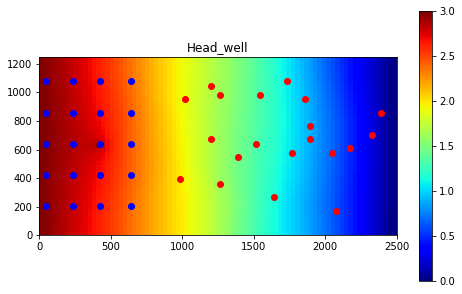

In [59]:
### wells and sensors
y_wel = np.array([6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34])# #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([1, 1, 1, 1, 1, 
         7, 7, 7, 7, 7,
         13, 13, 13, 13, 13,
         20, 20, 20, 20, 20])# #np.random.randint(low = 0, high = 25, size = 20)
wells = {i: [y_wel[i], x_wel[i]] for i in range(len(y_wel))}

np.random.seed(888)
y_obs = np.random.randint(low = 5, high = 35, size = 20)
x_obs = np.random.randint(low = 30, high = 80, size = 20)

dirname = 'binary_files'
model_ws = os.path.join(workdir, dirname)
hds = bf.HeadFile(os.path.join(model_ws, dirname + '_mf.hds'))
times = hds.get_times()  # simulation time, steady state
heads = hds.get_data(totim=times[-1])
hds.close()  # close the file object for the next run

head = heads[0]
head = np.flip(head, 0)
dx = 2500/80
dy = 1250/40

wel = {"x": list(dx/2 + x_wel*dx), "y": list(dy/2 + y_wel*dy)}
obs = {"x": list(dx/2 + x_obs*dx), "y": list(dy/2 + y_obs*dy)}
well_plot(head, 'Head_well',wel, obs)

In [119]:
my_model = mymf() #initialize the model
N_obs = []
N_maps = []
s = time.time()

##load the saved hydraulic conductivity
with open('hk', 'rb') as file:
    hk = pk.load(file)
    
for n in range(N):    
    cvt = my_model.run_model(hk, mod_wels[n], con_rate[n]) #this will delete the last simulation
    
    maps = my_model.figures()
    ##the observation extraction of flopy is different, do not use the following 2 lines
    ####obser = my_model.take_obs(cvt)
    ####N_obs.append(obser)
    ## mannually take the observations:
    N_obs.append([maps[i][(y_obs, x_obs)] for i in range(len(maps))])
    N_maps.append(maps)
#     my_model.make_movie()
#     my_model.simple_plot(maps[1],'')

### pickle the 1500 samples
# with open('/Volumes/GoogleDrive/My Drive/inverse_modeling/reactive_transport/net_files/1500samples','wb') as file:
#     pk.dump([x_ind, x, q, mod_wels, con_rate, N_obs, N_maps], file)
print('time:', time.time() - s)

time: 1848.48006606102


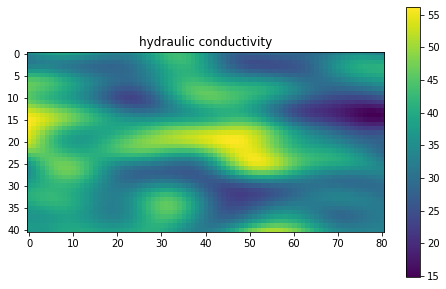

In [29]:
with open('hk', 'rb') as file:
    hk = pk.load(file)
fig, axs = plt.subplots(1,1)
c01map = axs.imshow(hk, interpolation='none')
fig.colorbar(c01map, ax=axs,shrink=0.62)
title = 'hydraulic conductivity'
name = title + '.pdf'
plt.title(title)
fig.savefig(name, format='pdf',bbox_inches='tight')

In [113]:
#10 samples take 13.01 s, 1500 might take 1951 s.
13.01*(150)

1951.5

In [120]:
print(x_ind[-1])
print(x[-1])
print(q[-1]) 
print(mod_wels[N-1])
print(con_rate[N-1])

12
[20, 13]
[849.         536.33333333 457.66666667 303.66666667 502.33333333
   3.         985.66666667 169.         849.66666667  63.66666667]
{0: [0, 20, 13, 849.0], 1: [0, 20, 13, 536.3333333333334], 2: [0, 20, 13, 457.6666666666667], 3: [0, 20, 13, 303.66666666666663], 4: [0, 20, 13, 502.3333333333333], 5: [0, 20, 13, 3.0], 6: [0, 20, 13, 985.6666666666667], 7: [0, 20, 13, 168.99999999999997], 8: [0, 20, 13, 849.6666666666665], 9: [0, 20, 13, 63.666666666666664], 10: [0, 20, 13, 0]}
{0: [0, 20, 13, 10000.0, 2], 1: [0, 20, 13, 10000.0, 2], 2: [0, 20, 13, 10000.0, 2], 3: [0, 20, 13, 10000.0, 2], 4: [0, 20, 13, 10000.0, 2], 5: [0, 20, 13, 10000.0, 2], 6: [0, 20, 13, 10000.0, 2], 7: [0, 20, 13, 10000.0, 2], 8: [0, 20, 13, 10000.0, 2], 9: [0, 20, 13, 10000.0, 2], 10: [0, 20, 13, 0.0, 2]}


## make input images(sources with location and injection rate)

In [4]:
N = 1500
with open('/Volumes/GoogleDrive/My Drive/inverse_modeling/reactive_transport/1500samples','rb') as file:
    [x_ind, x, q, mod_wels, con_rate, N_obs, N_maps] = pk.load(file)

In [99]:
N_inits = []
for i in range(N):
    inits = []
    for t in range(10):
        source = np.zeros((41, 81))
        source[x[i][0], x[i][1]] = mod_wels[i][t][3]
        inits.append(source)
    
    N_inits.append(inits)
#         my_model.simple_plot(N_maps[i][0],'2years')
#         my_model.simple_plot(source, 'source')

## pickle the sources maps
with open('/Volumes/GoogleDrive/My Drive/inverse_modeling/reactive_transport/net_files/sources','wb') as file:
    pk.dump([N_inits], file)

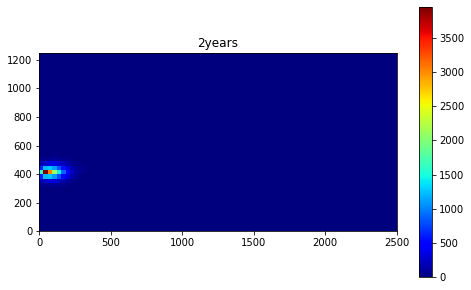

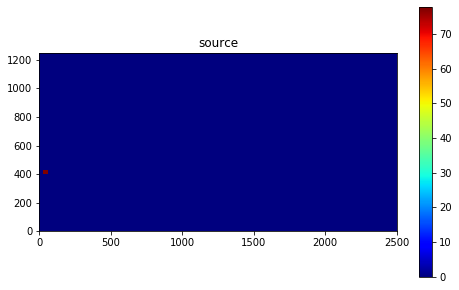

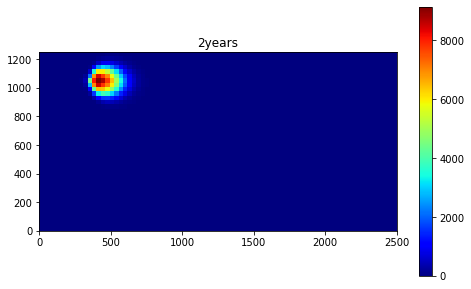

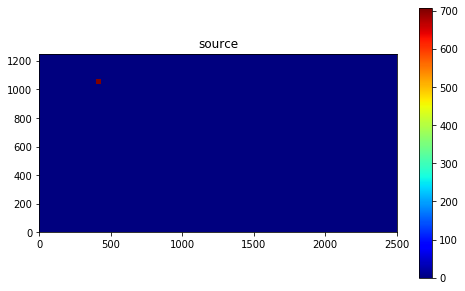

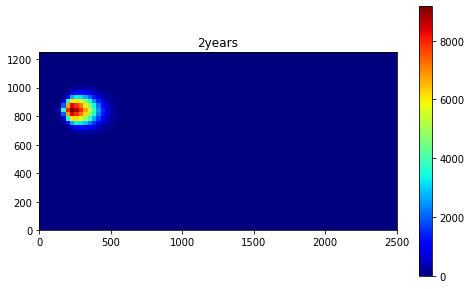

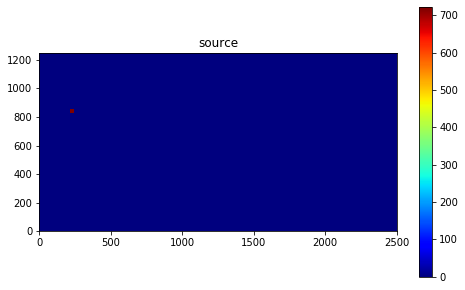

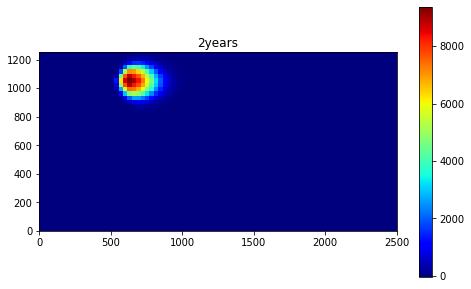

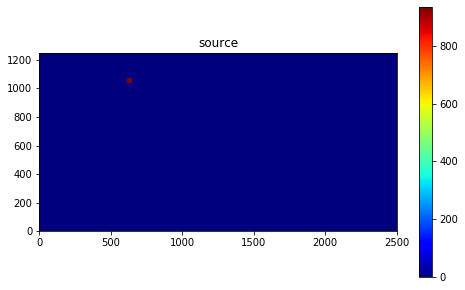

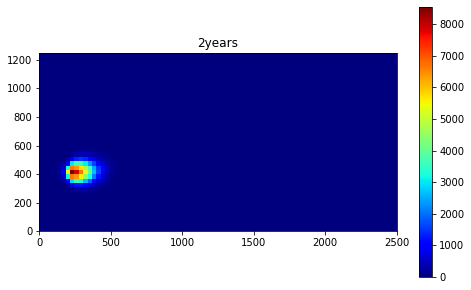

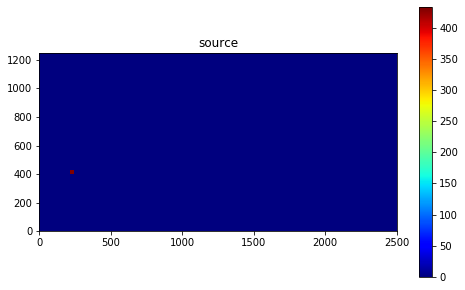

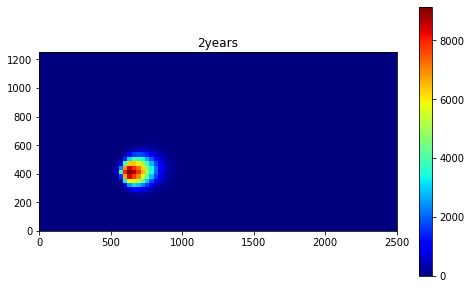

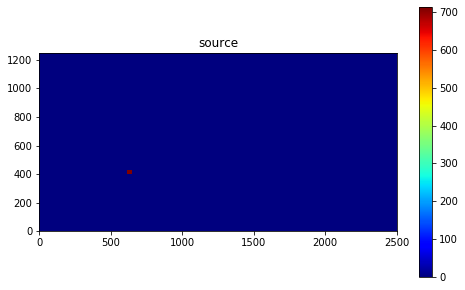

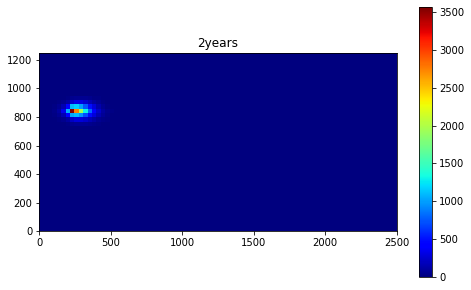

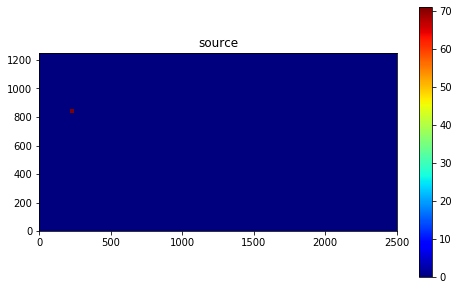

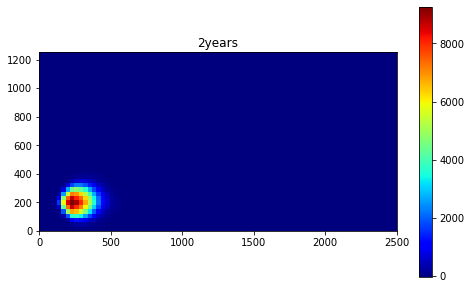

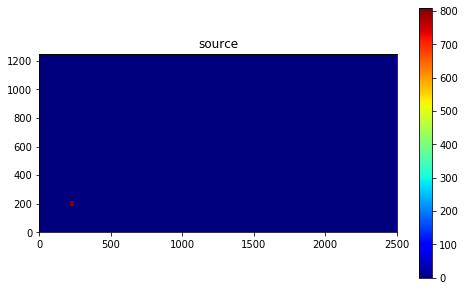

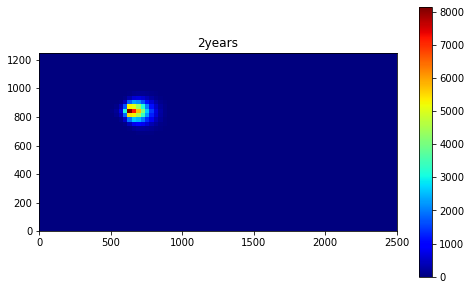

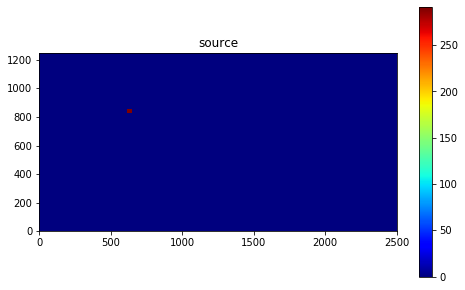

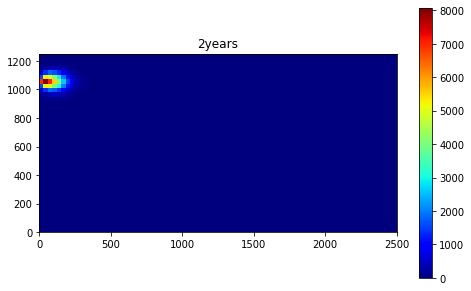

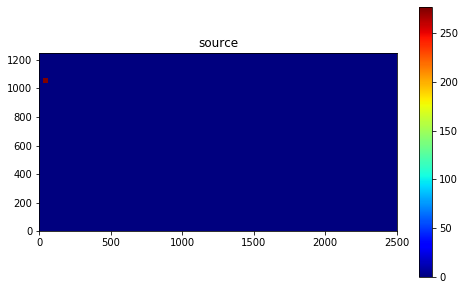

In [25]:
## check if the source maps are correctly made:
np.random.seed(888)
ind = np.random.randint(0, 1500, 10)
for i in ind:
    my_model.simple_plot(N_maps[i][0],'2years')
    my_model.simple_plot(N_inits[i][0], 'source')


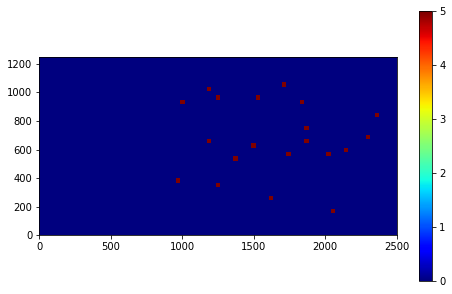

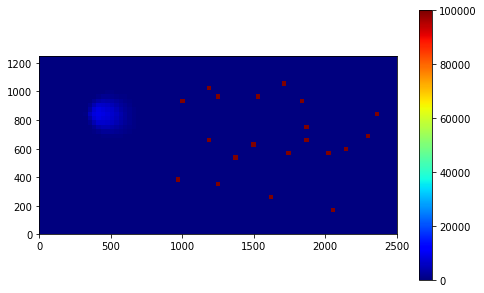

In [107]:
## make sure the sensor location indexs can extract the pixels correctly
np.random.seed(888)
y_obs = np.random.randint(low = 5, high = 35, size = 20)
x_obs = np.random.randint(low = 30, high = 80, size = 20)
map0 = np.zeros((41, 81))
map0[(y_obs, x_obs)] +=  5
my_model.simple_plot(map0,'')

test = N_maps[0][0]
test[(y_obs, x_obs)] = 100000
my_model.simple_plot(test,'')

In [105]:
## had to use the following code to extract the observation
N_obs = []
for n in range(N):    
    maps = N_maps[n]
    ##the observation extraction of flopy is different, do not use the following 2 lines
    ####obser = my_model.take_obs(cvt)
    ####N_obs.append(obser)
    ## mannually take the observations:
    N_obs.append([maps[i][(y_obs, x_obs)] for i in range(len(maps))])
    
print(len(N_obs))
print(len(N_obs[0]))
print(N_obs[0][0] == N_maps[0][0][(y_obs, x_obs)])

# with open('/Volumes/GoogleDrive/My Drive/inverse_modeling/reactive_transport/net_files/1500samples','wb') as file:
#     pk.dump([x_ind, x, q, mod_wels, con_rate, N_obs, N_maps], file)

1500
50
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [112]:
head[-1]

array([3.        , 2.973514  , 2.9475589 , 2.921847  , 2.8961434 ,
       2.8702471 , 2.8439817 , 2.8171887 , 2.7897232 , 2.7614524 ,
       2.7322543 , 2.702017  , 2.6706412 , 2.6380432 , 2.6041596 ,
       2.5689542 , 2.5324275 , 2.4946263 , 2.4556513 , 2.4156656 ,
       2.374894  , 2.3336153 , 2.2921474 , 2.2508233 , 2.209963  ,
       2.1698484 , 2.1307025 , 2.0926766 , 2.0558488 , 2.0202281 ,
       1.9857632 , 1.952355  , 1.9198678 , 1.8881392 , 1.856989  ,
       1.8262249 , 1.7956473 , 1.7650534 , 1.7342402 , 1.7030089 ,
       1.6711706 , 1.6385537 , 1.6050147 , 1.5704498 , 1.5348077 ,
       1.498098  , 1.4603934 , 1.4218206 , 1.382541  , 1.3427225 ,
       1.3025128 , 1.2620155 , 1.2212791 , 1.180296  , 1.1390096 ,
       1.0973306 , 1.0551537 , 1.012377  , 0.9689207 , 0.9247431 ,
       0.879854  , 0.8343218 , 0.78827316, 0.7418842 , 0.6953633 ,
       0.6489282 , 0.60278213, 0.5570924 , 0.5119768 , 0.46749693,
       0.42366055, 0.38042784, 0.3377216 , 0.2954375 , 0.25345